In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from abc import ABC, abstractmethod


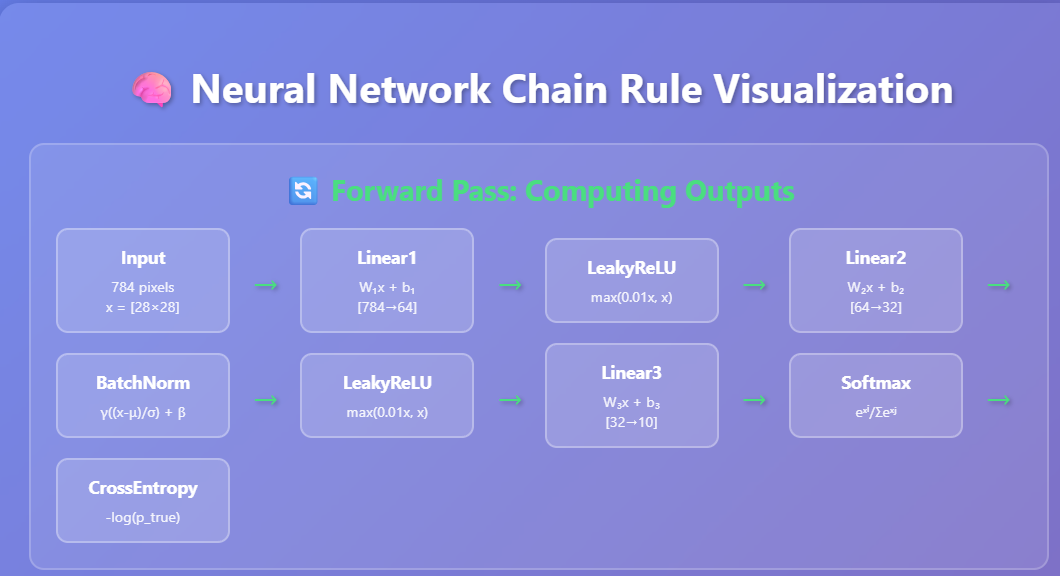


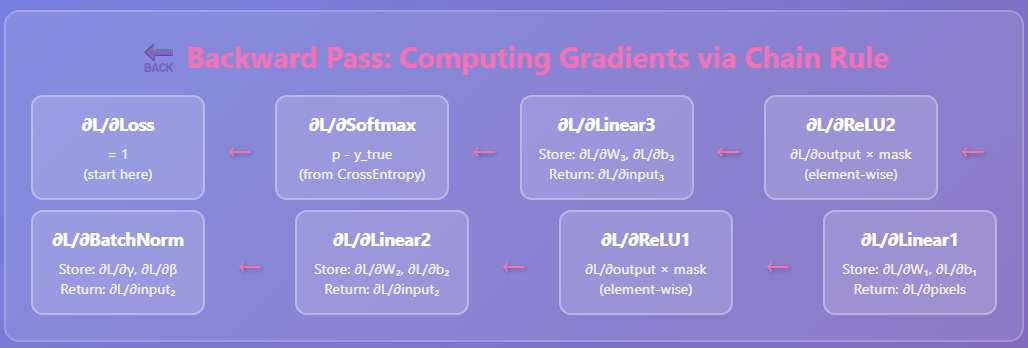



In [2]:
# Download MNIST dataset and normalize it
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(
    root="./data", train=True, transform=transform, download=True
)
test_dataset = datasets.MNIST(
    root="./data", train=False, transform=transform, download=True
)

# Convert to NumPy arrays
train_images = train_dataset.data.numpy().reshape(-1, 28 * 28) / 255.0
train_labels = train_dataset.targets.numpy()

test_images = test_dataset.data.numpy().reshape(-1, 28 * 28) / 255.0
test_labels = test_dataset.targets.numpy()

# Neural Network Inheritance Class

In [3]:
class Module(ABC):
    def __init__(self):
        self.training = True

    def forward(self, x):
        raise NotImplementedError

    def backward(self, grad_output):
        raise NotImplementedError

    def parameters(self):
        """Return list of parameter dictionaries"""
        params = []
        for attr_name in dir(self):
            attr = getattr(self, attr_name)
            if isinstance(attr, Module):
                params.extend(attr.parameters())
            elif hasattr(attr, "shape") and attr_name.endswith(("weight", "bias")):
                # Add module reference to avoid conflicts
                params.append(
                    {
                        "name": f"{id(self)}_{attr_name}",
                        "value": attr,
                        "module": self,
                        "attr_name": attr_name,
                    }
                )
        return params

    def gradients(self):
        """Return list of gradient dictionaries"""
        grads = []
        for attr_name in dir(self):
            attr = getattr(self, attr_name)
            if isinstance(attr, Module):
                grads.extend(attr.gradients())
            elif hasattr(attr, "shape") and attr_name.endswith("_grad"):
                # Add module reference to match with parameters
                grads.append(
                    {
                        "name": f"{id(self)}_{attr_name}",
                        "value": attr,
                        "module": self,
                        "attr_name": attr_name,
                    }
                )
        return grads

    def train(self):
        self.training = True
        for attr_name in dir(self):
            attr = getattr(self, attr_name)
            if isinstance(attr, Module):
                attr.train()

    def eval(self):
        self.training = False
        for attr_name in dir(self):
            attr = getattr(self, attr_name)
            if isinstance(attr, Module):
                attr.eval()

# Layers

In [4]:
class Linear(Module):
    """
    A class defining a linear layer in an MLP:

    Init:
    * Weights [out x in] drawn from N(0, 1) scaled by sqrt 2/in  for Kaiming - He init.
    https://arxiv.org/abs/1502.01852v1 (Kaiming He et. al. - used for initializing, ReLU, and LeakyReLU)
    * Biases [out, 1] populated with zeros (0's), the popped 1 is for shape

    Forward:
    * cache_input saves layer input X for backward pass and backprop
    * w@x+b does linear function from in_dim to out_dim

    Backward:
    * recalls cached X and extracts data dimension (X.shape[1])
    * solves for gradients in W and b, (dW and db) and updates via backpropagation of errors (chain-rule)

    Params:
    * returns the parameters dictionary

    grads:
    * returns the gradients dictionary
    """

    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        # Kaiming He initialization
        self.weight = np.random.randn(out_features, in_features) * np.sqrt(
            2.0 / in_features
        )
        self.bias = np.zeros((out_features, 1))

        # Gradients
        self.weight_grad = None
        self.bias_grad = None
        self.input_cache = None

    def forward(self, x):
        self.input_cache = x
        return self.weight @ x + self.bias

    def backward(self, grad_output):
        """
        CRUCIAL: This method does TWO different things with gradients:

        1. STORES gradients for THIS layer's parameters (weight, bias)
           - These stored gradients will be used by the optimizer to update THIS layer's weights
           - self.weight_grad tells us "how much should we change self.weight?"
           - self.bias_grad tells us "how much should we change self.bias?"

        2. RETURNS gradients for the PREVIOUS layer's outputs
           - This returned gradient flows backward to the previous layer
           - It tells the previous layer "how much did your outputs contribute to the loss?"

        Think of it like passing a message backward:
        - "Hey previous layer, here's how your outputs affected the loss" (return value)
        - "Hey optimizer, here's how to update my weights" (stored in self.weight_grad)
        """
        batch_size = self.input_cache.shape[1]

        # Compute gradients
        # PART 1: Store gradients for THIS layer's parameters (for the optimizer to use later)
        # These tell the optimizer how to update self.weight and self.bias
        self.weight_grad = (1 / batch_size) * grad_output @ self.input_cache.T
        self.bias_grad = (1 / batch_size) * np.sum(grad_output, axis=1, keepdims=True)

        # Return gradient w.r.t. input
        # PART 2: Return gradients for the PREVIOUS layer's outputs (to continue backprop)
        # This flows backward to tell the previous layer how its outputs affected the loss
        return self.weight.T @ grad_output

In [5]:
class ReLU(Module):
    """
    ReLU activation function (https://arxiv.org/abs/1502.01852v1, Kaiming He et. al.):
    ReLU(x) = max(0, x)
    """

    def __init__(self):
        super().__init__()
        self.input_cache = None

    def forward(self, x):
        self.input_cache = x
        return np.maximum(0, x)

    def backward(self, grad_output):
        return grad_output * (self.input_cache > 0)

In [6]:
class LeakyReLU(Module):
    """
    LeakyReLU activation function (https://arxiv.org/abs/1502.01852v1, Kaiming He et. al.):
    LeakyReLU(x) = x if x>=0, or, alpha * x if x < 0
    """

    def __init__(self, negative_slope=0.01):
        super().__init__()
        self.negative_slope = negative_slope
        self.input_cache = None

    def forward(self, x):
        self.input_cache = x
        return np.where(x > 0, x, self.negative_slope * x)

    def backward(self, grad_output):
        return grad_output * np.where(self.input_cache > 0, 1, self.negative_slope)

In [7]:
class Softmax(Module):
    """
    Softmax activation function. Converts input into a vector of probabilities.
    """

    def __init__(self):
        super().__init__()
        self.output_cache = None

    def forward(self, x):
        exp_x = np.exp(x - np.max(x, axis=0, keepdims=True))
        self.output_cache = exp_x / np.sum(exp_x, axis=0, keepdims=True)
        return self.output_cache

    def backward(self, grad_output):
        # This is typically handled by CrossEntropyLoss
        return grad_output  # derivative of cross-entropy + softmax

In [8]:
class BatchNorm1d(Module):
    """
    Batch Normalization - 1D case:
    Tracks mean and variance, normalizes them, then models them linearly, accelerating convergence.
    https://arxiv.org/abs/1502.03167,  Sergey Ioffe et. al.

    Init:
    * creates variables and populates with zero placeholders

    Forward:
    * finds mean and variance of input over the batch
    * Normalizes
    * updates running mean and variance

    Backwards:
    * backpropagates error through gamma and beta
    * returns error for layer above
    """

    def __init__(self, num_features, momentum=0.9, eps=1e-5):
        super().__init__()
        self.num_features = num_features
        self.momentum = momentum
        self.eps = eps

        # Learnable parameters
        self.weight = np.ones((num_features, 1))  # gamma
        self.bias = np.zeros((num_features, 1))  # beta

        # Running statistics
        self.running_mean = np.zeros((num_features, 1))
        self.running_var = np.ones((num_features, 1))

        # Gradients and cache
        self.weight_grad = None
        self.bias_grad = None
        self.input_cache = None
        self.normalized_cache = None
        self.batch_mean = None
        self.batch_var = None

    def forward(self, x):
        self.input_cache = x

        if self.training:
            self.batch_mean = np.mean(x, axis=1, keepdims=True)
            self.batch_var = np.var(x, axis=1, keepdims=True)

            self.normalized_cache = (x - self.batch_mean) / np.sqrt(
                self.batch_var + self.eps
            )
            output = self.weight * self.normalized_cache + self.bias

            # Update running statistics
            self.running_mean = (
                self.momentum * self.running_mean
                + (1 - self.momentum) * self.batch_mean
            )
            self.running_var = (
                self.momentum * self.running_var + (1 - self.momentum) * self.batch_var
            )
        else:
            normalized = (x - self.running_mean) / np.sqrt(self.running_var + self.eps)
            output = self.weight * normalized + self.bias

        return output

    def backward(self, grad_output):
        batch_size = grad_output.shape[1]

        # Gradients w.r.t. parameters
        self.weight_grad = np.sum(
            grad_output * self.normalized_cache, axis=1, keepdims=True
        )
        self.bias_grad = np.sum(grad_output, axis=1, keepdims=True)

        # Gradient w.r.t. input (complex BatchNorm backward pass)
        grad_normalized = grad_output * self.weight
        grad_var = np.sum(
            grad_normalized
            * (self.input_cache - self.batch_mean)
            * -0.5
            * (self.batch_var + self.eps) ** -1.5,
            axis=1,
            keepdims=True,
        )
        grad_mean = np.sum(
            grad_normalized * -1 / np.sqrt(self.batch_var + self.eps),
            axis=1,
            keepdims=True,
        ) + grad_var * np.mean(
            -2 * (self.input_cache - self.batch_mean), axis=1, keepdims=True
        )

        grad_input = (
            grad_normalized / np.sqrt(self.batch_var + self.eps)
            + grad_var * 2 * (self.input_cache - self.batch_mean) / batch_size
            + grad_mean / batch_size
        )

        return grad_input

# Optimizers

In [9]:
class SGDOptimizer:
    """
    Classic naieve stochastic gradient descent alpgorithm.
    Take a small step with slight stochasticity in the direction of the gradient
    """

    def __init__(self, learning_rate=0.01, jitter=1e-4):
        self.lr = learning_rate
        self.jitter = jitter

    def step(self, parameters, gradients):
        """Update parameters using gradients"""
        # Create lookup for gradients by matching parameter names
        grad_lookup = {
            g["name"]: g["value"] for g in gradients if g["value"] is not None
        }

        for param in parameters:
            param_name = param["name"]
            # Convert weight/bias name to corresponding grad name
            if param_name.endswith("weight"):
                grad_name = param_name.replace("weight", "weight_grad")
            elif param_name.endswith("bias"):
                grad_name = param_name.replace("bias", "bias_grad")
            else:
                continue

            if grad_name in grad_lookup:
                grad = grad_lookup[grad_name]
                lr_with_jitter = self.lr + np.random.randn() * self.jitter
                param["value"][:] -= lr_with_jitter * grad

In [10]:
class AdamOptimizer:
    """
    Adam Optimizer method from https://arxiv.org/abs/1412.6980, Diederik P. Kingma & Jimmy Ba

    Init:
    * populates params with presets/settings

    Step:
    * gets gradients
    * updates mean and variance moments (running means)
    * steps along gradient weighted by bias corrected moments
    """

    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.lr = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = epsilon
        self.t = 0

        # Initialize moment estimates (will be created dynamically)
        self.m = {}
        self.v = {}

    def step(self, parameters, gradients):
        """Update parameters using gradients"""
        self.t += 1

        # Create lookup for gradients by matching parameter names
        grad_lookup = {
            g["name"]: g["value"] for g in gradients if g["value"] is not None
        }

        for param in parameters:
            param_name = param["name"]
            # Convert weight/bias name to corresponding grad name
            if param_name.endswith("weight"):
                grad_name = param_name.replace("weight", "weight_grad")
            elif param_name.endswith("bias"):
                grad_name = param_name.replace("bias", "bias_grad")
            else:
                continue

            if grad_name in grad_lookup:
                grad = grad_lookup[grad_name]

                # Initialize moments if not exists
                if param_name not in self.m:
                    self.m[param_name] = np.zeros_like(param["value"])
                    self.v[param_name] = np.zeros_like(param["value"])

                # Update moments
                self.m[param_name] = (
                    self.beta1 * self.m[param_name] + (1 - self.beta1) * grad
                )
                self.v[param_name] = self.beta2 * self.v[param_name] + (
                    1 - self.beta2
                ) * (grad**2)

                # Bias correction
                m_hat = self.m[param_name] / (1 - self.beta1**self.t)
                v_hat = self.v[param_name] / (1 - self.beta2**self.t)

                # Update parameters
                param["value"][:] -= self.lr * m_hat / (np.sqrt(v_hat) + self.eps)

# Metrics

In [11]:
class CrossEntropyLoss:
    def __call__(self, predictions, targets):
        return self.forward(predictions, targets)

    def forward(self, predictions, targets):
        """Compute cross entropy loss"""
        batch_size = targets.shape[0]
        log_likelihood = -np.log(predictions[targets, np.arange(batch_size)] + 1e-9)
        return np.sum(log_likelihood) / batch_size

    def backward(self, predictions, targets):
        """Compute gradient of cross entropy + softmax"""
        batch_size = targets.shape[0]
        grad = predictions.copy()
        grad[targets, np.arange(batch_size)] -= 1
        return grad / batch_size

In [12]:
def compute_accuracy(Y_hat, Y_true):
    preds = np.argmax(Y_hat, axis=0)
    return np.mean(preds == Y_true)

# Training Process

In [13]:
def train_model(
    model,
    optimizer,
    train_data,
    train_labels,
    val_data,
    val_labels,
    epochs=5,
    batch_size=64,
):
    """Training loop with PyTorch-like interface"""
    criterion = CrossEntropyLoss()
    num_samples = train_data.shape[0]

    for epoch in range(epochs):
        model.train()  # Set to training mode

        # Shuffle data
        permutation = np.random.permutation(num_samples)
        train_data = train_data[permutation]
        train_labels = train_labels[permutation]

        epoch_loss = 0
        epoch_acc = 0

        for i in range(0, num_samples, batch_size):
            batch_data = train_data[i : i + batch_size]
            batch_labels = train_labels[i : i + batch_size]

            if batch_data.shape[0] == 0:
                continue

            # Forward pass
            predictions = model.forward(batch_data)
            loss = criterion(predictions, batch_labels)
            acc = np.mean(np.argmax(predictions, axis=0) == batch_labels)

            # Backward pass
            loss_grad = criterion.backward(predictions, batch_labels)
            model.backward(loss_grad)

            # Update parameters
            parameters = model.parameters()
            gradients = model.gradients()
            optimizer.step(parameters, gradients)

            epoch_loss += loss * batch_data.shape[0]
            epoch_acc += acc * batch_data.shape[0]

        # Validation
        model.eval()  # Set to evaluation mode
        val_predictions = model.forward(val_data)
        val_loss = criterion(val_predictions, val_labels)
        val_acc = np.mean(np.argmax(val_predictions, axis=0) == val_labels)

        avg_train_loss = epoch_loss / num_samples
        avg_train_acc = epoch_acc / num_samples

        print(
            f"Epoch {epoch+1}/{epochs} | "
            f"Train Loss: {avg_train_loss:.4f}, Acc: {avg_train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}"
        )

In [14]:
def test_model(network, X_test, Y_test):
    """
    A function to test a neural network model on MNIST digit classification given a test dataset.
    """
    Y_pred_probs = network.forward(X_test)
    Y_pred = np.argmax(Y_pred_probs, axis=0)
    accuracy = np.mean(Y_pred == Y_test)
    print(f"Test Accuracy: {accuracy:.4f} or {accuracy * 100 :.2f}%")

    return Y_pred

In [15]:
def show_examples(X, Y_true, Y_pred, correct=True, n=5):
    """
    A function to visualize model performance by showing first n examples of correct and incorrect classifications
    """
    indices = [i for i in range(len(Y_true)) if (Y_pred[i] == Y_true[i]) == correct]
    selected = random.sample(indices, min(n, len(indices)))

    plt.figure(figsize=(10, 4))
    for i, idx in enumerate(selected):
        plt.subplot(1, n, i + 1)
        plt.imshow(X[idx].reshape(28, 28), cmap="gray")
        plt.axis("off")
        plt.title(f"Label: {Y_true[idx]}\nPred: {Y_pred[idx]}")
    plt.suptitle("Correctly Classified" if correct else "Misclassified", fontsize=14)
    plt.show()

# Model Creation

In [16]:
class NeuralNetwork(Module):
    def __init__(self):
        super().__init__()
        self.layer1 = Linear(784, 64)
        self.activation1 = LeakyReLU()
        self.layer2 = Linear(64, 32)
        self.batch_norm = BatchNorm1d(32)
        self.activation2 = LeakyReLU()
        self.layer3 = Linear(32, 10)
        self.softmax = Softmax()

    def forward(self, x):
        x = x.T  # Transpose for your matrix format
        x = self.layer1.forward(x)
        x = self.activation1.forward(x)
        x = self.layer2.forward(x)
        x = self.batch_norm.forward(x)
        x = self.activation2.forward(x)
        x = self.layer3.forward(x)
        x = self.softmax.forward(x)
        return x

    def backward(self, loss_grad):
        grad = self.softmax.backward(loss_grad)
        grad = self.layer3.backward(grad)
        grad = self.activation2.backward(grad)
        grad = self.batch_norm.backward(grad)
        grad = self.layer2.backward(grad)
        grad = self.activation1.backward(grad)
        grad = self.layer1.backward(grad)
        return grad

# Demo

In [17]:
# Split Data
X_train, X_val, Y_train, Y_val = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42
)

# Initialize model
model = NeuralNetwork()

# Initialize optimizer
optimizer = AdamOptimizer(learning_rate=0.01)
# optimizer = SGDOptimizer(params, learning_rate=0.01)

train_model(model, optimizer, X_train, Y_train, X_val, Y_val, epochs=5, batch_size=64)

Epoch 1/5 | Train Loss: 0.2544, Acc: 0.9226 | Val Loss: 0.1433, Acc: 0.9571
Epoch 2/5 | Train Loss: 0.1306, Acc: 0.9596 | Val Loss: 0.1256, Acc: 0.9630
Epoch 3/5 | Train Loss: 0.0982, Acc: 0.9688 | Val Loss: 0.1046, Acc: 0.9676
Epoch 4/5 | Train Loss: 0.0819, Acc: 0.9739 | Val Loss: 0.0970, Acc: 0.9732
Epoch 5/5 | Train Loss: 0.0718, Acc: 0.9768 | Val Loss: 0.0988, Acc: 0.9717


Test Accuracy: 0.9723 or 97.23%


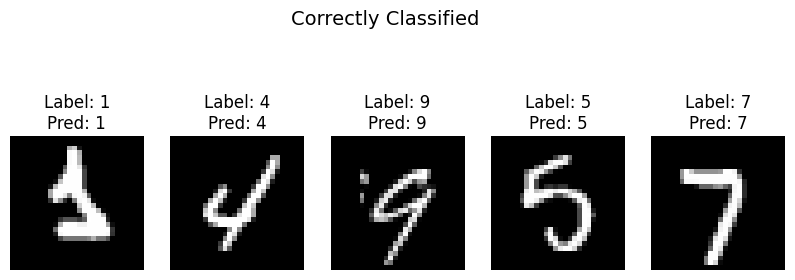

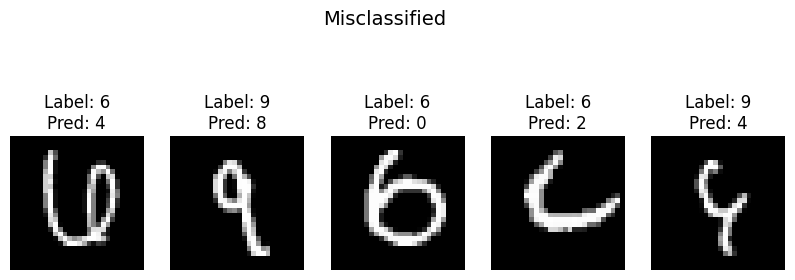

In [18]:
# Evaluate on test set
Y_test_pred = test_model(model, test_images, test_labels)

# Show correct and incorrect predictions
show_examples(test_images, test_labels, Y_test_pred, correct=True, n=5)
show_examples(test_images, test_labels, Y_test_pred, correct=False, n=5)

In [19]:
# You can access individual layers
print(model.layer1.weight.shape)
model.layer1.weight *= 0.5  # Modify weights directly

# Set training/eval modes
model.train()  # Sets all layers to training mode
model.eval()  # Sets all layers to eval mode (affects BatchNorm, Dropout, etc.)

(64, 784)


# Demo 2 with SGD Optimizer

In [20]:
# Split Data
X_train, X_val, Y_train, Y_val = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42
)

# Initialize model
model = NeuralNetwork()

# Initialize optimizer
# optimizer = AdamOptimizer(learning_rate=0.01)
optimizer = SGDOptimizer(learning_rate=0.01)

train_model(model, optimizer, X_train, Y_train, X_val, Y_val, epochs=50, batch_size=64)

Epoch 1/50 | Train Loss: 2.2949, Acc: 0.1941 | Val Loss: 2.0010, Acc: 0.2995
Epoch 2/50 | Train Loss: 1.8314, Acc: 0.3952 | Val Loss: 1.6584, Acc: 0.4842
Epoch 3/50 | Train Loss: 1.5497, Acc: 0.5257 | Val Loss: 1.4147, Acc: 0.5761
Epoch 4/50 | Train Loss: 1.3339, Acc: 0.6039 | Val Loss: 1.2269, Acc: 0.6381
Epoch 5/50 | Train Loss: 1.1714, Acc: 0.6593 | Val Loss: 1.0865, Acc: 0.6807
Epoch 6/50 | Train Loss: 1.0462, Acc: 0.6994 | Val Loss: 0.9716, Acc: 0.7173
Epoch 7/50 | Train Loss: 0.9476, Acc: 0.7289 | Val Loss: 0.8824, Acc: 0.7462
Epoch 8/50 | Train Loss: 0.8675, Acc: 0.7517 | Val Loss: 0.8098, Acc: 0.7671
Epoch 9/50 | Train Loss: 0.8039, Acc: 0.7700 | Val Loss: 0.7561, Acc: 0.7848
Epoch 10/50 | Train Loss: 0.7512, Acc: 0.7852 | Val Loss: 0.7074, Acc: 0.7992
Epoch 11/50 | Train Loss: 0.7062, Acc: 0.7985 | Val Loss: 0.6658, Acc: 0.8122
Epoch 12/50 | Train Loss: 0.6673, Acc: 0.8104 | Val Loss: 0.6323, Acc: 0.8207
Epoch 13/50 | Train Loss: 0.6370, Acc: 0.8196 | Val Loss: 0.6007, Acc: 0.

Test Accuracy: 0.9132 or 91.32%


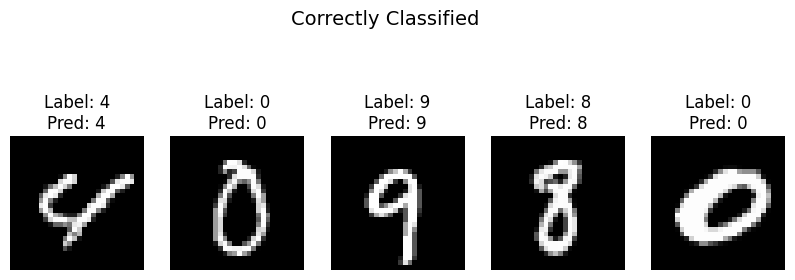

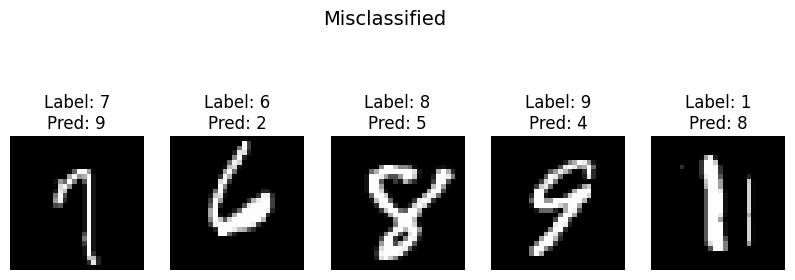

In [21]:
# Evaluate on test set
Y_test_pred = test_model(model, test_images, test_labels)

# Show correct and incorrect predictions
show_examples(test_images, test_labels, Y_test_pred, correct=True, n=5)
show_examples(test_images, test_labels, Y_test_pred, correct=False, n=5)